## 4. MODEL SELECTION AND HYPERPARAMETER TUNING

In [2]:
# 4. Model Selection and Hyperparameter Tuning
#    4.1. Dependencies and Imports
#    4.2. Imputation Strategy
#    4.3. Pipelines
#    4.4. Optimization and Best Hyperparameters
#       4.4.1. Optuna Hyperparameter Optimization
#       4.4.2. Elastic Net Tuning
#       4.4.3. Random Forest Tuning
#       4.4.4. XGBRegressor Tuning
#       

# 5. SHAP Values
#    5.1. SHAP Summary Plot
#    5.2. SHAP Beeswarm-style Plot
#    5.3. SHAP Summary Plot

# 6. Model Performance plots
#    6.1. Model Performance Metrics Plot
#    6.2. Actual vs. Predicted Sale Price Plot

##### 4.1. Dependencies and Imports

In [3]:
# set working directory
import os
os.getcwd()

'/Users/gaby/Documents/NYCDSA/ML project'

In [4]:
# Dependencies & Imports

import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt

from sklearn import ensemble
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import ElasticNet

import shap, json, optuna, joblib
from xgboost import XGBRegressor

/Users/gaby/.venvs/py3129/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
# Load and split the data 
df = pd.read_pickle("df.pkl")
df.head()

X = df.drop(columns=['SalePrice'])
y = df['SalePrice']

##### 4.2. Define imputation strategy

In [6]:
# IDENTIFY DUMMIES
dummy_cols = [
    col for col in df.select_dtypes(include='number').columns
    if set(df[col].dropna().unique())<={0,1}] # True if set is {},{0},{1},{0,1}

In [7]:
# DEFINE NUMERIC AND CATEGORICAL COLUMNS
numbers_cols = df.select_dtypes(include='number').columns.drop('SalePrice') # drop saleprice from numeric_cols

numeric_cols = numbers_cols.drop(dummy_cols)
print("----numeric_cols-------")
print(numeric_cols)
print(len(numeric_cols))

categorical_cols = df.select_dtypes(exclude='number').columns
print("----categorical_cols-------")
print(categorical_cols)
print(len(categorical_cols))
print("----dummy_cols-------")

# dummy columns
print(dummy_cols)
print(len(dummy_cols))
len(df.columns)

----numeric_cols-------
Index(['GrLivArea', 'MSSubClass', 'LotFrontage', 'LotArea', 'LotShape',
       'LandSlope', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'HeatingQC', 'Electrical',
       '1stFlrSF', '2ndFlrSF', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', 'ScreenPorch', 'Fence', 'MiscVal', 'MoSold', 'YrSold'],
      dtype='object')
52
----categorical_cols-------
Index(['MSZoning', 'Alley', 'LandContour', 'LotConfig', 'Neighborhood',
       'Condition1', 'BldgType', 'HouseStyle', 'RoofS

71

In [8]:
# Value counts for numeric columns
with pd.option_context('display.max_rows', None):
    for col in numeric_cols:
        print(df[col].value_counts(dropna=False))

GrLivArea
864     38
1040    25
1092    24
1456    15
816     14
912     14
1200    14
848     13
894     13
987     12
1728    12
960     11
936     11
988     10
1337     9
1652     8
990      8
1302     8
1440     8
1560     8
1479     8
1680     8
1362     7
1218     7
1768     7
1656     7
1144     7
1792     7
1344     7
1430     7
882      7
1072     7
1422     7
1008     7
1224     7
1382     7
1056     7
1501     6
1416     6
1432     6
1626     6
1494     6
1664     6
1484     6
1232     6
1342     6
1604     6
1226     6
630      6
1374     6
1694     6
1709     6
925      6
1152     6
1080     6
1324     6
1320     6
1392     6
1716     6
1710     5
1306     5
1442     5
1720     5
1646     5
1436     5
1358     5
1671     5
1488     5
1470     5
1196     5
1548     5
768      5
1721     5
1176     5
1512     5
1800     5
1034     5
1573     5
1576     5
914      5
1414     5
1632     5
1216     5
672      5
1114     5
1350     4
1556     4
1126     4
1360     4
1298     4


##### 4.3. Pipelines

In [9]:
# SEPARATE NUMERIC COLUMNS INTO SKEWED AND NOT SKEWED IN ORDER TO APPLY
# IMPUTATION AND SCALING

# Check for skewness in numerical columns
skewness = df[numeric_cols].skew().abs()

# Set the threshold for skewness
threshold = 1

# separate numerical column into skewed and not skewed
numeric_cols_skewed = [col for col in numeric_cols if skewness[col]>1]
numeric_cols_not_skewed = [col for col in numeric_cols if skewness[col]<=1]

In [10]:
# BUILD PIPELINES

# Pipeline numeric skewed, impute median and use min max scaler
numeric_pipeline_skewed     = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
     ('scaler', MinMaxScaler()),
     ])
# Pipeline numeric not skewed impute mean and use standard scaler
numeric_pipeline_not_skewed = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
     ('scaler', StandardScaler()),
     ])
# Pipeline categorical impute mode and use one hot encoder
categorical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
    ])

In [11]:
# PREPROCESSING PIPELINES
# Build preprocessor through combining pipelines in one Column Transformer
preprocessor = ColumnTransformer(transformers=[
        ('numeric_skewed', numeric_pipeline_skewed, numeric_cols_skewed), 
        ('numeric_not_skewed', numeric_pipeline_not_skewed, numeric_cols_not_skewed), 
        ('dummy_cols', 'passthrough', dummy_cols),
        ('cat', categorical_pipeline, categorical_cols)
    ])

In [12]:
# MODEL PIPELINES

# Model pipeline Random Forest
pipeline_rf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', RandomForestRegressor()) 
])

# Model pipeline XGBoost
pipeline_xgb = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', XGBRegressor())  
])

# Model pipeline elastic net
pipeline_enet = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', ElasticNet())
])

### 4.4 Optimization and best hyperparameters

In [13]:
# SPLIT INTO TRAIN AND TEST SETS
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

##### 4.4.1. Optuna-Powered Hyperparameter Optimization

In [14]:
# OBJECTIVE FUNCTIONS FOR OPTUNA-BASED HYPERPARAMETER TUNING 
def objective_rf(trial):
    params = {
      'model__n_estimators':      trial.suggest_int('model__n_estimators',     100, 500),
      'model__max_depth':         trial.suggest_int('model__max_depth',          5, 30),
      'model__min_samples_split': trial.suggest_int('model__min_samples_split',  2, 10),
      'model__random_state':      42,
      'model__n_jobs':            -1,
    }
    pipe = Pipeline([
      ('preprocessor', preprocessor),
      ('model', RandomForestRegressor())
    ]).set_params(**params)
    return cross_val_score(pipe, X_train, y_train,
                           cv=5,
                           scoring='neg_root_mean_squared_error',
                           n_jobs=-1).mean()

def objective_xgb(trial):
    params = {
      'model__n_estimators':      trial.suggest_int('model__n_estimators',     100, 500),
      'model__max_depth':         trial.suggest_int('model__max_depth',         2, 32, log=True),
      'model__learning_rate':     trial.suggest_float('model__learning_rate',1e-4,1.0,log=True),
      'model__subsample':         trial.suggest_float('model__subsample',       0.5,1.0),
      'model__colsample_bytree':  trial.suggest_float('model__colsample_bytree',0.5,1.0),
      'model__random_state':      42,
      'model__n_jobs':            -1,
      'model__objective':         'reg:squarederror'
    }
    pipe = Pipeline([
      ('preprocessor', preprocessor),
      ('model', XGBRegressor())
    ]).set_params(**params)
    return cross_val_score(pipe, X_train, y_train,
                           cv=5,
                           scoring='neg_root_mean_squared_error',
                           n_jobs=-1).mean()

def objective_enet(trial):
    params = {
        'model__alpha':      trial.suggest_float('model__alpha',    1e-4, 1.0, log=True),
        'model__l1_ratio':   trial.suggest_float('model__l1_ratio', 0.0,  1.0),
        'model__max_iter':   10_000,
        'model__random_state': 42
    }
    pipe = pipeline_enet.set_params(**params)
    return cross_val_score(
        pipe, X_train, y_train,
        cv=5,
        scoring='neg_root_mean_squared_error',
        n_jobs=-1
    ).mean()

In [15]:
# PACKAGE INTO A DICTIONARY
models = {
  "RandomForest": {
     "objective": objective_rf,
     "pipeline":   Pipeline([('preprocessor', preprocessor), ('model', RandomForestRegressor())]),
     "save_as":    "best_rf_pipeline.joblib",
     "params_file": "best_rf_params.json"
  },
  "XGBRegressor": {
     "objective": objective_xgb,
     "pipeline":   Pipeline([('preprocessor', preprocessor),
                             ('model', XGBRegressor(objective='reg:squarederror',
                                                    n_jobs=-1, random_state=42))
                                                    ]),
     "save_as":    "best_xgb_pipeline.joblib",
     "params_file": "best_xgb_params.json"
  },

   "ElasticNet": {
        "objective":   objective_enet,
        "pipeline":    pipeline_enet,
        "save_as":     "best_enet_pipeline.joblib",
        "params_file": "best_enet_params.json"
    }
}
# Here I can add other models like SVR, LGBM, etc.

In [16]:
# METRICS TO PRINT OUT
def print_metrics(name, model):
    preds = model.predict(X_test)
    mse   = mean_squared_error(y_test, preds)
    rmse  = np.sqrt(mse)
    mae   = mean_absolute_error(y_test, preds)
    r2    = r2_score(y_test, preds)
    print(f"\n--- {name} Metrics ---")
    print(f"MSE:   {mse:.4f}")
    print(f"RMSE:  {rmse:.4f}")
    print(f"MAE:   {mae:.4f}")
    print(f"R²:    {r2:.4f}")

##### 4.4.2. Elastic Net Tuning

In [17]:
# ELASTIC NET TUNING
print("\n>> Tuning ElasticNet …")
study_enet = optuna.create_study(direction='maximize')
study_enet.optimize(objective_enet, n_trials=500)

best_params_enet = study_enet.best_params
with open("enet_params.json", "w") as f:
    json.dump(best_params_enet, f, indent=2)

pipe_enet = models['ElasticNet']['pipeline'].set_params(**best_params_enet)
pipe_enet.fit(X_train, y_train)

joblib.dump(pipe_enet, "best_enet_pipeline.joblib")
print_metrics("ElasticNet", pipe_enet)

[I 2025-05-31 08:10:08,483] A new study created in memory with name: no-name-74c70860-80a6-4063-b083-38e08cf929ce



>> Tuning ElasticNet …


[I 2025-05-31 08:10:12,334] Trial 0 finished with value: -22001.186070349457 and parameters: {'model__alpha': 0.0018322056680869165, 'model__l1_ratio': 0.3473792354807236}. Best is trial 0 with value: -22001.186070349457.
/Users/gaby/.venvs/py3129/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.990e+09, tolerance: 9.125e+08
  model = cd_fast.enet_coordinate_descent(
/Users/gaby/.venvs/py3129/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.924e+09, tolerance: 8.971e+08
  model = cd_fast.enet_coordinate_descent(
/Users/gaby/.venvs/py3129/lib/python3.12/site-pack


--- ElasticNet Metrics ---
MSE:   496019812.6951
RMSE:  22271.5023
MAE:   14935.6528
R²:    0.9101


##### 4.4.3. Random Forest Tuning

In [18]:
# RANDOM FOREST TUNING

os.environ["PYDEVD_DISABLE_FILE_VALIDATION"] = "1"

print("\n>> Tuning Random Forest …")
study_rf = optuna.create_study(direction='maximize')
study_rf.optimize(objective_rf, n_trials=500, catch=(KeyboardInterrupt,))

best_params_rf = study_rf.best_params

# save parameters to JSON
with open("rf_params.json", "w") as f:
    json.dump(best_params_rf, f, indent=2)

# refit
pipe_rf = models['RandomForest']['pipeline'].set_params(**best_params_rf)
pipe_rf.fit(X_train, y_train)

# save pipeline
joblib.dump(pipe_rf, "best_rf_pipeline.joblib")
print_metrics("Random Forest", pipe_rf)

[I 2025-05-31 08:18:27,647] A new study created in memory with name: no-name-4e1ec4cb-4226-4dc9-b627-af5601a11d82



>> Tuning Random Forest …


[I 2025-05-31 08:18:39,300] Trial 0 finished with value: -23142.877608023293 and parameters: {'model__n_estimators': 439, 'model__max_depth': 20, 'model__min_samples_split': 7}. Best is trial 0 with value: -23142.877608023293.
[I 2025-05-31 08:18:45,684] Trial 1 finished with value: -23187.549171834555 and parameters: {'model__n_estimators': 239, 'model__max_depth': 16, 'model__min_samples_split': 7}. Best is trial 0 with value: -23142.877608023293.
[I 2025-05-31 08:18:56,985] Trial 2 finished with value: -23231.837040742514 and parameters: {'model__n_estimators': 444, 'model__max_depth': 19, 'model__min_samples_split': 8}. Best is trial 0 with value: -23142.877608023293.
[I 2025-05-31 08:19:01,770] Trial 3 finished with value: -22997.366382382017 and parameters: {'model__n_estimators': 162, 'model__max_depth': 17, 'model__min_samples_split': 4}. Best is trial 3 with value: -22997.366382382017.
[I 2025-05-31 08:19:07,301] Trial 4 finished with value: -23798.287036702146 and parameters:


--- Random Forest Metrics ---
MSE:   552281132.7084
RMSE:  23500.6624
MAE:   14186.4304
R²:    0.8999


In [19]:
##### 4.4.4. XGBREGRESSOR TUNING

In [23]:
# XGBREGRESOR TUNING
print("\n>> Tuning XGBoost …")
study_xgb = optuna.create_study(direction='maximize')
study_xgb.optimize(objective_xgb, n_trials=500)

best_params_xgb = study_xgb.best_params
with open("xgb_params.json", "w") as f:
    json.dump(best_params_xgb, f, indent=2)

pipe_xgb = models['XGBRegressor']['pipeline'].set_params(**best_params_xgb)
pipe_xgb.fit(X_train, y_train)

joblib.dump(pipe_xgb, "best_xgb_pipeline.joblib")
print_metrics("XGBoost", pipe_xgb)

[I 2025-05-31 13:01:18,906] A new study created in memory with name: no-name-cc83fb37-e58a-4fe5-a2f5-2f8ccc170ba9



>> Tuning XGBoost …


[I 2025-05-31 13:01:22,163] Trial 0 finished with value: -72444.7828125 and parameters: {'model__n_estimators': 162, 'model__max_depth': 2, 'model__learning_rate': 0.0002525393250155661, 'model__subsample': 0.8907337945699947, 'model__colsample_bytree': 0.6234704368966824}. Best is trial 0 with value: -72444.7828125.
[I 2025-05-31 13:01:25,918] Trial 1 finished with value: -28436.47890625 and parameters: {'model__n_estimators': 360, 'model__max_depth': 7, 'model__learning_rate': 0.5121494761705139, 'model__subsample': 0.5630620127441746, 'model__colsample_bytree': 0.9271414161460863}. Best is trial 1 with value: -28436.47890625.
[I 2025-05-31 13:01:29,073] Trial 2 finished with value: -20077.0265625 and parameters: {'model__n_estimators': 374, 'model__max_depth': 7, 'model__learning_rate': 0.018060152326242064, 'model__subsample': 0.6666478363558737, 'model__colsample_bytree': 0.786798250033774}. Best is trial 2 with value: -20077.0265625.
[I 2025-05-31 13:01:35,784] Trial 3 finished w


--- XGBoost Metrics ---
MSE:   384622304.0000
RMSE:  19611.7899
MAE:   12329.9336
R²:    0.9303


## 5. SHAP Values

### 4.5.1. SHAP Summary Plot

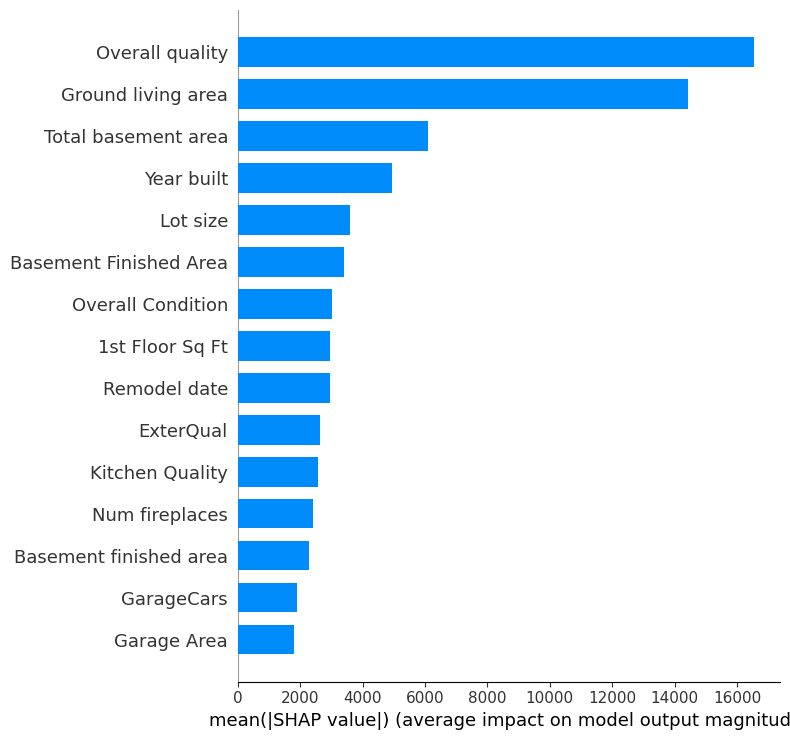

In [ ]:
# load the fitted pipeline
xgb_pipe = joblib.load("best_xgb_pipeline.joblib")

# grab preprocessor and XGB model
preproc = xgb_pipe.named_steps['preprocessor']
model   = xgb_pipe.named_steps['model']

feature_names = preproc.get_feature_names_out()
clean_names = [name.split("__")[-1] for name in feature_names]


# Re-create encoded training set as a DataFrame 
X_transformed = preproc.transform(X_train)
X_train_transformed = pd.DataFrame(X_transformed, columns=clean_names)

# rename the columns
rename_dict = {
    'OverallQual':  'Overall quality',
    'GrLivArea':    'Ground living area',
    'TotalBsmtSF':  'Total basement area',
    'YearBuilt':    'Year built',
    'BsmtFinSF1':   'Basement Finished Area',
    'OverallCond':  'Overall Condition',
    'LotArea':      'Lot size',
    'YearRemodAdd': 'Remodel date',
    'KitchenQual':  'Kitchen Quality',
    '1stFlrSF':     '1st Floor Sq Ft',
    'GarageArea':   'Garage Area',
    'BsmtFinType1': 'Basement finished area',
    'BsmtExposure': 'Basement exposure',
    'Fireplaces':   'Num fireplaces',
    '2ndFlrSF':     '2nd Floor Sq Ft',
    'GarageFinish': 'Garage Finish',
    'BsmtQual':     'Basement height'
}

X_train_transformed.rename(columns=rename_dict, inplace=True)

# Build a SHAP Explainer for a tree-based model
explainer = shap.TreeExplainer(model)
shap_exp  = explainer(X_train_transformed)

shap.summary_plot(shap_exp.values,
                  X_train_transformed, 
                  plot_type="bar", 
                  max_display=15)

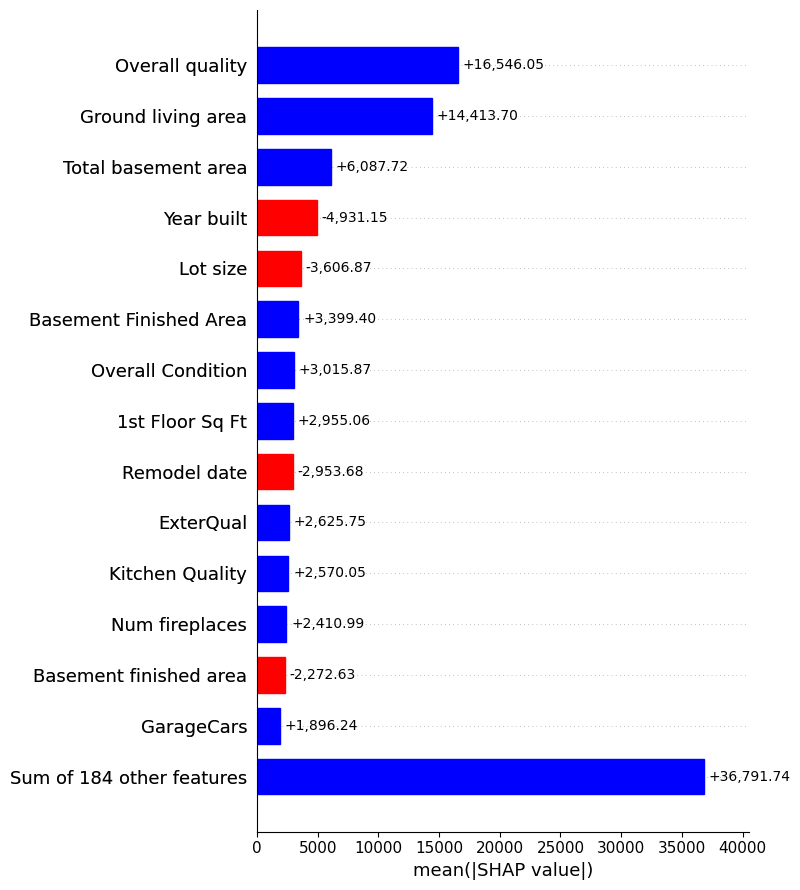

In [ ]:
# Load saved XGB pipeline, which was best performing model
xgb_pipe = joblib.load("best_xgb_pipeline.joblib")
preproc   = xgb_pipe.named_steps['preprocessor']
model     = xgb_pipe.named_steps['model']

# Clean & transform training data
raw_feats    = preproc.get_feature_names_out()
clean_feats  = [name.split("__")[-1] for name in raw_feats]      # drop any prefix before last "__"
X_transformed = preproc.transform(X_train)                        # a NumPy array
X_df         = pd.DataFrame(X_transformed, columns=clean_feats)   # back to DataFrame

# rename the specific columns you care about
rename_dict = {
    'OverallQual':  'Overall quality',
    'GrLivArea':    'Ground living area',
    'TotalBsmtSF':  'Total basement area',
    'YearBuilt':    'Year built',
    'BsmtFinSF1':   'Basement Finished Area',
    'OverallCond':  'Overall Condition',
    'LotArea':      'Lot size',
    'YearRemodAdd': 'Remodel date',
    'KitchenQual':  'Kitchen Quality',
    '1stFlrSF':     '1st Floor Sq Ft',
    'GarageArea':   'Garage Area',
    'BsmtFinType1': 'Basement finished area',
    'BsmtExposure': 'Basement exposure',
    'Fireplaces':   'Num fireplaces',
    '2ndFlrSF':     '2nd Floor Sq Ft',
    'GarageFinish': 'Garage Finish',
    'BsmtQual':     'Basement height'
}
X_df.rename(columns=rename_dict, inplace=True)

# Compute SHAP values
explainer  = shap.TreeExplainer(model)
shap_exp   = explainer(X_df)      # shap.Explanation object
# Note: shap_exp.values is shape (n_samples, n_features_transformed)

# Draw the bar‐type summary plot
fig = shap.plots.bar(shap_exp, max_display=15, show=False)
ax  = plt.gca()

# Strip out auto‐added text labels
for txt in list(ax.texts):
    txt.remove()

# Re‐color & re‐label each bar
# Build a DataFrame of |SHAP| so you can compute correlations
shap_df = pd.DataFrame(np.abs(shap_exp.values), columns=X_df.columns)

for bar, feat in zip(ax.patches[:15], shap_exp.feature_names):
    corr = np.corrcoef(shap_df[feat], X_df[feat])[0,1]
    color = 'blue' if corr > 0 else 'red'
    bar.set_color(color)

    sign  = '+' if corr > 0 else '-'
    val   = bar.get_width()
    label = f"{sign}{val:,.2f}"
    
    ax.text(
        val + ax.get_xlim()[1]*0.01,
        bar.get_y() + bar.get_height()/2,
        label,
        va='center',
        color='black'
    )

# show
plt.tight_layout()
plt.show()

# Mean absolute SHAP values indicate how much each 
# variable impacts the predicted house price.


##### Feature representation
Each feature’s Shapley value reflects its average contribution to the prediction when considering all possible combinations of features.

This approach helps show how much each feature influences the model’s output. In this case, features like "overall quality" and "above ground living area" had the strongest positive effects, whereas "age of the house" contributed negatively.



https://www.aidancooper.co.uk/a-non-technical-guide-to-interpreting-shap-analyses/?xgtab&
https://www.aidancooper.co.uk/how-shapley-values-work/

GrLivArea is the second most influential feature in the model (mean impact ≈ $16 k).

The fact that its bar is red tells you that, in the dataset, bigger houses actually pull the model’s prediction down relative to the baseline (perhaps because very large homes in the data come with features that the model “discounts” on average).

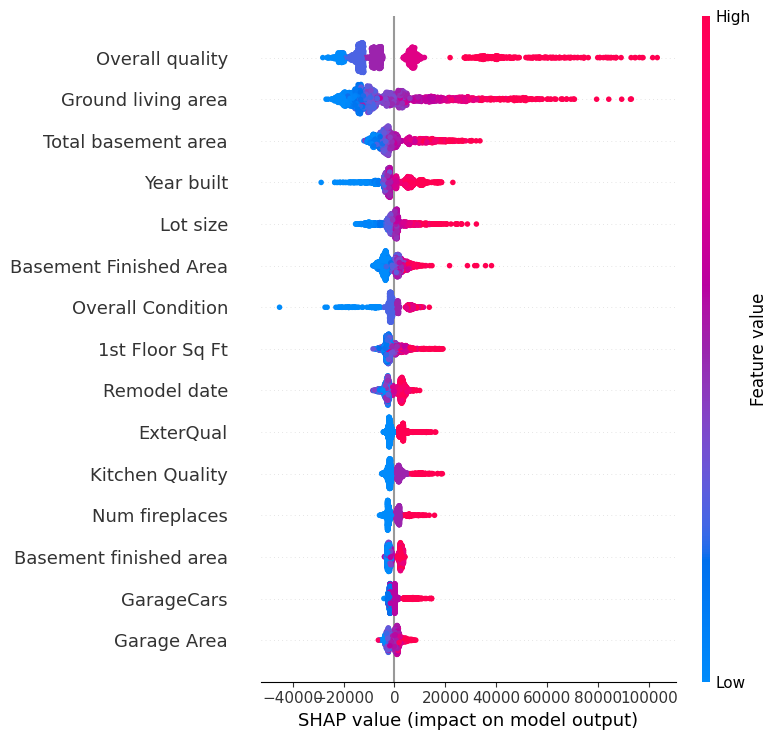

In [ ]:
# Beeswarm‐style (dot) plot

explainer = shap.TreeExplainer(model)
shap_exp   = explainer(X_df)  

shap.summary_plot(
    shap_exp.values,
    X_train_transformed,
    plot_type="dot",
    max_display=15
)

For OverallQual you would expect to see its high quality homes (reds) pulling the SHAP value positive—boosting price—while low quality homes (blues) push the SHAP value negative—lowering the predicted sale price.

##### 4.6. Actual vs. Predicted Sale Price Plot

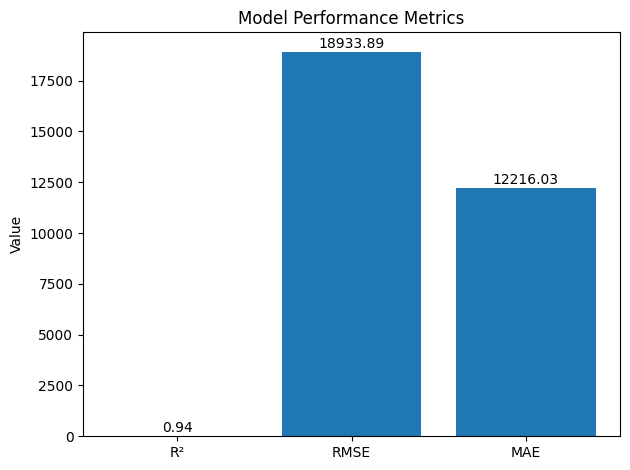

In [ ]:
# Generate predictions and compute metrics
# load best XGB pipeline
pipe_xgb = joblib.load("best_xgb_pipeline.joblib")

# Generate predictions and compute metrics
y_pred = pipe_xgb.predict(X_test)

mse  = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae  = mean_absolute_error(y_test, y_pred)
r2   = r2_score(y_test, y_pred)

# Bar chart of performance metrics
plt.figure()
metrics = ['R²', 'RMSE', 'MAE']
values  = [r2, rmse, mae]
plt.bar(metrics, values)
plt.title('Model Performance Metrics')
plt.ylabel('Value')

# Add bar values
for i, v in enumerate(values):
    plt.text(i, v + max(values)*0.01, f"{v:.2f}", ha='center')

plt.tight_layout()
plt.show()

##### 4.7. Actual vs. Predicted Sale Price Plot

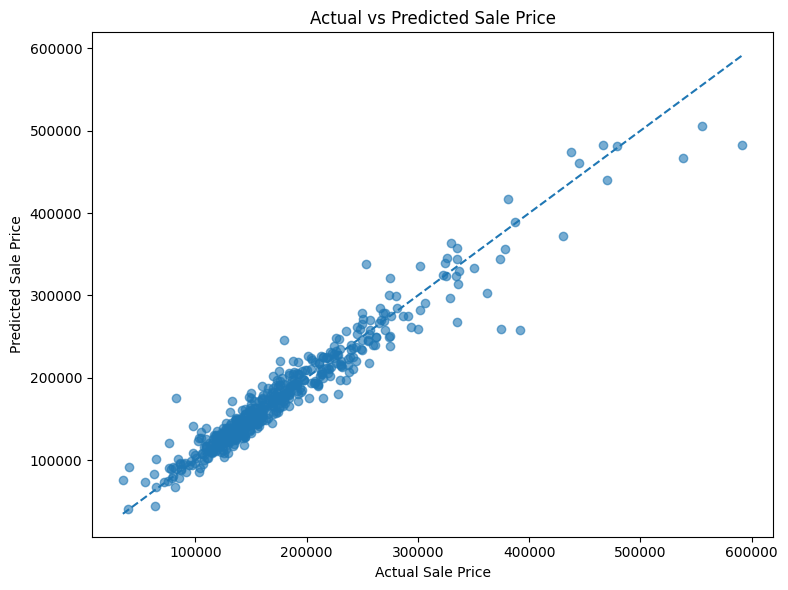

In [ ]:
# Scatter plot of Actual vs Predicted sale Price
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.6)
min_val = min(y_test.min(), y_pred.min())
max_val = max(y_test.max(), y_pred.max())
plt.plot([min_val, max_val], [min_val, max_val], linestyle='--')
plt.title('Actual vs Predicted Sale Price')
plt.xlabel('Actual Sale Price')
plt.ylabel('Predicted Sale Price')
plt.tight_layout()
plt.show()